# Heart Disease Binary Classification

### Import libraries

In [1]:
'''
THE CODE FOR THIS CELL WAS PROVIDED BY THE TA'S OF MAJID SARRAFZADEH'S CS M148 CLASS AT UCLA
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

from sklearn.naive_bayes import GaussianNB

### Define helper function

In [2]:
'''
THE CODE FOR THIS CELL WAS PROVIDED BY THE TA'S OF MAJID SARRAFZADEH'S CS M148 CLASS AT UCLA
'''
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Data Analysis

### Load data set

In [3]:
heartdisease = pd.read_csv("./heartdisease.csv")

### Preview data

In [4]:
heartdisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


### Generate descriptive statistics

In [5]:
heartdisease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


### Summarize data

In [6]:
heartdisease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


### Analyze features

All of the features in the data set are numeric and therefore do not need to be converted. However, the target is a boolean and will therefore need to be converted via a method like one hot encoding.

### Impute missing data

In [7]:
heartdisease[heartdisease.isnull().any(axis = 1)].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick


There are no null values! :)

### Encode categorical data

In [8]:
heartdisease["sick"] = heartdisease["sick"].astype(int)

### Histogram features

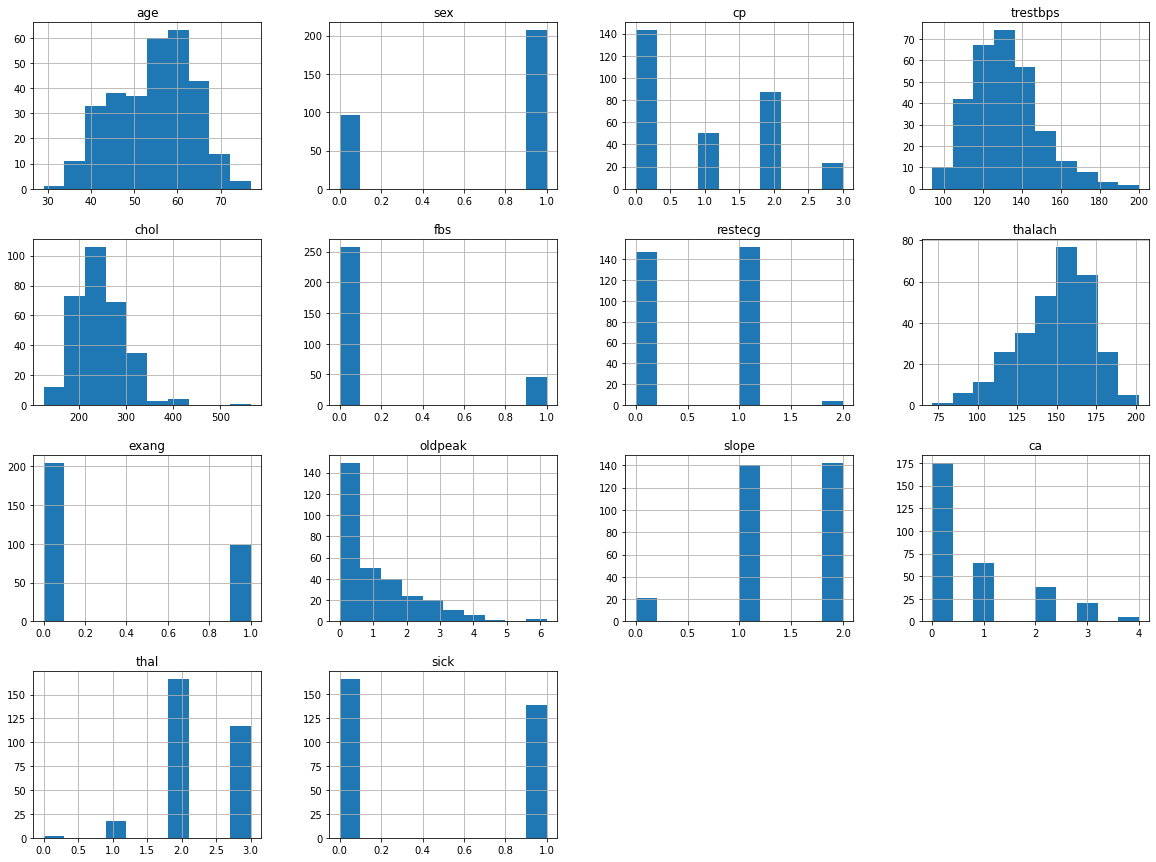

In [9]:
heartdisease.hist(figsize = (20, 15));

### Balance data set

Sick: 138
Healthy: 165


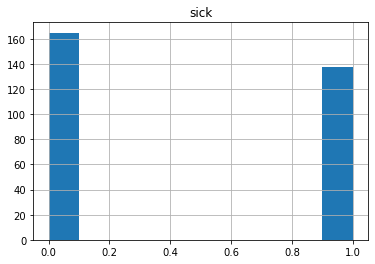

In [10]:
heartdisease.hist(column = "sick")

sick = 0
not_sick = 0

for i in heartdisease["sick"]:
    if i:
        sick += 1
    else:
        not_sick += 1
        
print("Sick:", sick)
print("Healthy:", not_sick)

There are 138 sick individuals and 165 healthy individuals in the data set. Therefore, it is relatively balanced.

### Analyze artificial balancing

Artificially balancing a data set can be problematic because the degree to which a data set is balanced is an attribute of its own of the data set and modifying it can have unintended consequences. In particular, artificial balancing may remove data points that define important properties of the original data set and adversely affect descriptive statistics like mean, median, and variance. This would, in turn, affect the accuracy of any models that rely on these statistics, like kNN.

### Correlation matrix

In [11]:
correlation_matrix = heartdisease.corr()
correlation_matrix["sick"].sort_values(ascending = False)

sick        1.000000
exang       0.436757
oldpeak     0.430696
ca          0.391724
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg    -0.137230
slope      -0.345877
thalach    -0.421741
cp         -0.433798
Name: sick, dtype: float64

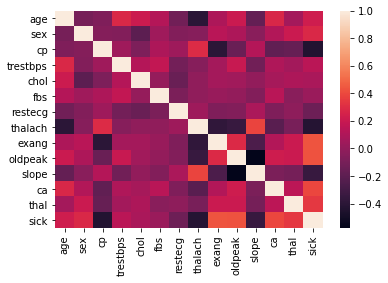

In [12]:
sns.heatmap(correlation_matrix);

Some variables correlate more highly than others simply because they describe related or similar conditions. For example, there is moderate correlation between exercise induced angina and heart disease because many people that experience angina may do so as a result of heart disease. The same reasoning can be used to explain moderate correlation between depression induced by exercise relative to rest and heart disease, and number of major vessels colored by flourosopy and heart disease: patients that exhibit symptoms of an unhealthy heart are more likely to also suffer from heart disease. The lack of correlation between some variables can also be explained in the same way. For example, there is no correlation between fasting blood sugar and heart disease because blood sugar is more an indicator of ailments like diabetes than heart disease. The two variables are completely unrelated and therefore there is no correlation between them.

## Data Preprocessing and KNN

### Drop label

In [13]:
heartdisease_y = heartdisease["sick"]
heartdisease_x = heartdisease.drop("sick", axis = 1)

### Split data set

In [14]:
x_train, x_test, y_train, y_test = train_test_split(heartdisease_x,
                                                    heartdisease_y,
                                                    test_size = 0.2,
                                                    random_state = 42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

### Train baseline KNN

In [15]:
baseline_knn = KNeighborsClassifier()
baseline_knn.fit(x_train, y_train)

baseline_knn_y_pred = baseline_knn.predict(x_test)

metrics.accuracy_score(y_test, baseline_knn_y_pred)

0.6885245901639344

### Pipeline

In [16]:
heartdisease_numerical_features = heartdisease_x.drop(["sex",
                                                       "cp",
                                                       "fbs",
                                                       "restecg",
                                                       "exang",
                                                       "slope",
                                                       "ca",
                                                       "thal"],
                                                      axis = 1)
numerical_features_list = list(heartdisease_numerical_features)

categorical_features_list = ["sex",
                             "cp",
                             "fbs",
                             "restecg",
                             "exang",
                             "slope",
                             "ca",
                             "thal"]

numerical_feature_pipeline = Pipeline([
    ("standard_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("numerical_features", numerical_feature_pipeline, numerical_features_list),
    ("categorical_features", OneHotEncoder(), categorical_features_list)
])

heartdisease_prepared = full_pipeline.fit_transform(heartdisease_x)

### Split data set and train pipelined KNN

In [17]:
pipelined_x_train, pipelined_x_test, pipelined_y_train, pipelined_y_test = train_test_split(heartdisease_prepared,
                                                                                            heartdisease_y,
                                                                                            test_size = 0.2,
                                                                                            random_state = 42)

pipelined_knn = KNeighborsClassifier()
pipelined_knn.fit(pipelined_x_train, pipelined_y_train)

pipelined_knn_y_pred = pipelined_knn.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, pipelined_knn_y_pred)

0.9016393442622951

Scaling numerical features clearly affects kNN's accuracy significantly as our model now predicts with 90% accuracy as opposed to 69% earlier. The reason that this model is so much more accurate than the previous one is because the lack of feature scaling in the first model allowed features that were numerically larger to dominate features that were numerically smaller--a byproduct of kNN's reliance on Euclidean distance. In other words, features with larger magnitudes had larger Euclidean distances which diminished the impact on predictions of features with smaller magnitudes which had smaller Euclidean distances.

### Optimize KNN parameters

In [18]:
n_values = [1, 2, 3, 5, 7, 9, 10, 20, 50]

for n in n_values:
    parameter_optimization_knn = KNeighborsClassifier(n_neighbors = n)
    parameter_optimization_knn.fit(pipelined_x_train, pipelined_y_train)
    parameter_optimization_y_pred = parameter_optimization_knn.predict(pipelined_x_test)
    print(n, metrics.accuracy_score(pipelined_y_test, parameter_optimization_y_pred))

1 0.8032786885245902
2 0.8688524590163934
3 0.8688524590163934
5 0.9016393442622951
7 0.9016393442622951
9 0.8852459016393442
10 0.8852459016393442
20 0.9016393442622951
50 0.8852459016393442


## Additional Learning Methods

### Baseline logistic regression

In [19]:
baseline_logreg = LogisticRegression()
baseline_logreg.fit(pipelined_x_train, pipelined_y_train)

baseline_logreg_y_pred = baseline_logreg.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, baseline_logreg_y_pred), metrics.precision_score(pipelined_y_test, baseline_logreg_y_pred), metrics.recall_score(pipelined_y_test, baseline_logreg_y_pred), metrics.f1_score(pipelined_y_test, baseline_logreg_y_pred)

(0.8852459016393442, 0.8666666666666667, 0.896551724137931, 0.8813559322033899)

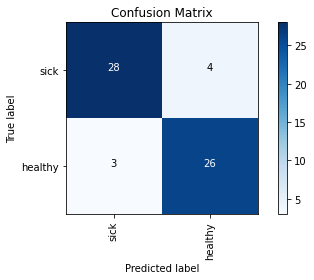

In [20]:
draw_confusion_matrix(pipelined_y_test, baseline_logreg_y_pred, ["sick", "healthy"])

### Analyze metrics

Accuracy tells us how often our model issues a correct prediction. This is accomplished by dividing the sum of the number of true positives and the number of true negatives by the number of total predictions. We value maximizing accuracy when we want to maximize the number of true positives and the number of true negatives.

Precision tells us how often our model doesn't issue a false positive prediction. This is accomplished by dividing the number of true positives by the sum of the number of true positives and the number of false positives. We value maximizing precision when we want to minimize the number of false positives. For example, we would want to maximize precision when predicting if someone is who they say they are when opening a credit card.

Recall tells us how often our model doesn't issue a false negative prediction. This is accomplished by dividing the number of true positives by the sum of the number of true positives and the number of false negatives. We value maximizing recall when we want to minimize the number of false negatives. For example, we would want to maximize recall when predicting if someone has a life threatening disease.

F1 score tells us how often our model doesn't issue a false positive or false negative prediction. This is accomplished by dividing two times recall times precision by the sum of recall and precision. We value maximizing F1 score when we want to minimize both the number of false positives and the number of false negatives. For example, we would want to maximize F1 score when predicting if someone committed a crime.

### Graph ROC curve

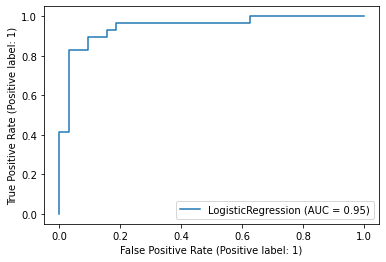

In [21]:
metrics.plot_roc_curve(baseline_logreg, pipelined_x_test, pipelined_y_test);

### Analyze ROC curve

An ROC curve plots the relationship between true positive rate and false positive rate for a given classifier. The results of this graph seem to be indicating an area under the curve (AUC) of 0.95 which is relatively large and therefore suggests that logistic regression is a good classifier for the heart disease data set provided.

### Modified logistic regression

In [22]:
modified_logreg = LogisticRegression(solver = "sag", max_iter = 10, penalty = "none")
modified_logreg.fit(pipelined_x_train, pipelined_y_train)

modified_logreg_y_pred = modified_logreg.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, modified_logreg_y_pred), metrics.precision_score(pipelined_y_test, modified_logreg_y_pred), metrics.recall_score(pipelined_y_test, modified_logreg_y_pred), metrics.f1_score(pipelined_y_test, modified_logreg_y_pred)

/Users/nshaikh/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


(0.8852459016393442, 0.8666666666666667, 0.896551724137931, 0.8813559322033899)

### Modified logistic regression 2

In [23]:
modified_logreg2 = LogisticRegression(solver = "sag", max_iter = 1500, penalty = "none")
modified_logreg2.fit(pipelined_x_train, pipelined_y_train)

modified_logreg2_y_pred = modified_logreg2.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, modified_logreg2_y_pred), metrics.precision_score(pipelined_y_test, modified_logreg2_y_pred), metrics.recall_score(pipelined_y_test, modified_logreg2_y_pred), metrics.f1_score(pipelined_y_test, modified_logreg2_y_pred)

(0.8688524590163934,
 0.8620689655172413,
 0.8620689655172413,
 0.8620689655172413)

### Analyze modified logistic regressions

I increased the maximum iterations from 10 to 1500. Even though I fixed the problem, this approach may have harmed the outcome by increasing the processing power required by the model. Furthermore, the metrics are actually slightly worse now which means that there was no benefit to running extra iterations. Finally, setting the penalty parameter to "none" likely also impacted this result by getting rid of the L2 penalty for regularization (effectively increasing the computational complexity of the model and encouraging overfitting).

### Modified logistic regression 3

In [24]:
modified_logreg3 = LogisticRegression(solver = "liblinear", penalty = "l1")
modified_logreg3.fit(pipelined_x_train, pipelined_y_train)

modified_logreg3_y_pred = modified_logreg3.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, modified_logreg3_y_pred), metrics.precision_score(pipelined_y_test, modified_logreg3_y_pred), metrics.recall_score(pipelined_y_test, modified_logreg3_y_pred), metrics.f1_score(pipelined_y_test, modified_logreg3_y_pred)

(0.8852459016393442, 0.8666666666666667, 0.896551724137931, 0.8813559322033899)

### Analyze logistic regression solvers

The two solver approaches are liblinear and sag. According to the sklearn documentation, liblinear uses the one-vs-rest approach to multiclass logistic regression and is best for small data sets while sag uses the true multinomial approach to multiclass logistic regression and is fast for large data sets.

### Analyze penalty term

The purpose of a penalty term is to decide how heavily errors are weighed in regularization. An L1 penalty works by calculating the L1 norm (also known as the Manhattan distance, the sum of the horizontal and vertical distances between two points) and multiplying it by some constant. The product is then added to the output of a loss function to create a regularized loss function.

### Support vector machine (SVM)

In [25]:
baseline_svm = SVC(probability = True)
baseline_svm.fit(pipelined_x_train, pipelined_y_train)

baseline_svm_y_pred = baseline_svm.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, baseline_svm_y_pred), metrics.precision_score(pipelined_y_test, baseline_svm_y_pred), metrics.recall_score(pipelined_y_test, baseline_svm_y_pred), metrics.f1_score(pipelined_y_test, baseline_svm_y_pred)

(0.9016393442622951, 0.8709677419354839, 0.9310344827586207, 0.9)

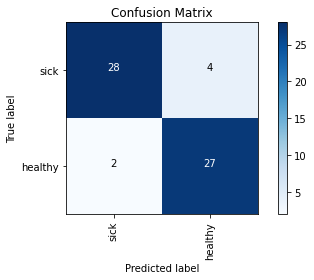

In [26]:
draw_confusion_matrix(pipelined_y_test, baseline_svm_y_pred, ["sick", "healthy"])

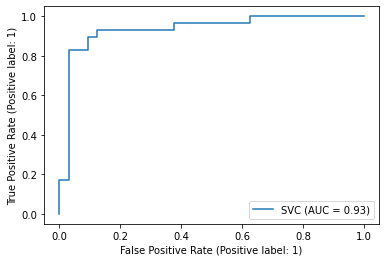

In [27]:
metrics.plot_roc_curve(baseline_svm, pipelined_x_test, pipelined_y_test);

### Modified SVM

In [28]:
modified_svm = SVC(probability = True, kernel = "linear")
modified_svm.fit(pipelined_x_train, pipelined_y_train)

modified_svm_y_pred = modified_svm.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, modified_svm_y_pred), metrics.precision_score(pipelined_y_test, modified_svm_y_pred), metrics.recall_score(pipelined_y_test, modified_svm_y_pred), metrics.f1_score(pipelined_y_test, modified_svm_y_pred)

(0.8688524590163934, 0.8387096774193549, 0.896551724137931, 0.8666666666666666)

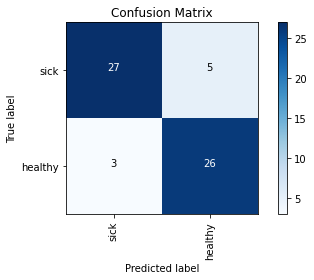

In [29]:
draw_confusion_matrix(pipelined_y_test, modified_svm_y_pred, ["sick", "healthy"])

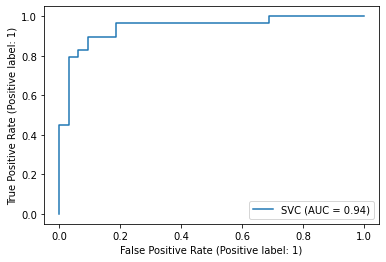

In [30]:
metrics.plot_roc_curve(modified_svm, pipelined_x_test, pipelined_y_test);

### Analyze modified SVM

The new results that I have achieved are just slightly less accurate than the previous ones as there are now more false positives and false negatives. The only difference is that this model uses a linear kernel which is generally faster while the previous one uses a radial basis functioning (rbf) kernel which is generally better but nonlinear. In other words, an rbf kernel has a higher computational cost associated with it due to its nonlinearity but it is usually able to produce a more accurate model. Despite this, the model produced by a linear kernel is often good enough. In this case, the linear kernel is just slightly worse than the nonlinear rbf kernel and the marginal benefit of the rbf kernel is likely not worth the computational cost incurred.

### Analyze logistic regression versus SVM

The difference between logistic regression and linear SVM when it comes to defining a boundary is that logistic regression relies on an s-shaped curve (also known as a sigmoid curve or a logistic curve) with a designated threshold for positive and negative values while SVM simply identifies the optimal hyperplane. For example, logistic regression may predict that all data points with a probability of 0.5 or higher are positive while SVM will simply check which side of the hyperplane a data point is on. In other words, logistic regression relies more on statistical analysis while SVM relies more on geometric analysis.

### Bayesian classification

In [31]:
nbc = GaussianNB()
nbc.fit(pipelined_x_train, pipelined_y_train)

nbc_y_pred = nbc.predict(pipelined_x_test)

metrics.accuracy_score(pipelined_y_test, nbc_y_pred), metrics.precision_score(pipelined_y_test, nbc_y_pred), metrics.recall_score(pipelined_y_test, nbc_y_pred), metrics.f1_score(pipelined_y_test, nbc_y_pred)

(0.4918032786885246,
 0.48214285714285715,
 0.9310344827586207,
 0.6352941176470589)

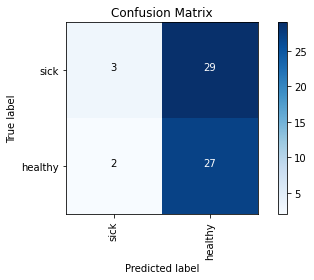

In [32]:
draw_confusion_matrix(pipelined_y_test, nbc_y_pred, ["sick", "healthy"])

In [33]:
print("31 mislabeled points: 29 false negatives and 2 false positives")

31 mislabeled points: 29 false negatives and 2 false positives


### Analyze Bayesian classification

This model has a horrendous accuracy of just over 49%. In addition, there is a relatively large number of mislabeled points, especially when compared to logistic regression and SVM. The reason for this mislabeling is likely the inaccurate assumption that the features in the data set are conditionally independent. This was discussed earlier in this project and I established that some variables are dependent simply because they describe related or similar conditions.

### Cross validation

In [34]:
kfold = KFold(n_splits = 10, random_state = 42, shuffle = True)

logreg_model = LogisticRegression()
svm_model = SVC(probability = True)

logreg_kfold = cross_val_score(logreg_model, pipelined_x_train, pipelined_y_train, cv = kfold)
svm_kfold = cross_val_score(svm_model, pipelined_x_train, pipelined_y_train, cv = kfold)

logreg_kfold.mean(), svm_kfold.mean()

(0.8468333333333333, 0.8431666666666666)

Logistic regression with an L2 penalty and the default solver (lbfgs) is my best performing model with an accuracy of just under 85%. However, SVM with probability estimates enabled is not far behind with an accuracy of just over 84%.